In [1]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [3]:
# Importing dependencies

import numpy as np
np.random.seed(1)
import tensorflow as tf 
tf.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

### Data Preprocessing

In [6]:
# Loading the dataset
#url = 'https://raw.githubusercontent.com/ninja3697/dataset/master/CSV.csv'
url = 'DSE13-21.xlsx'
df = pd.read_excel(url,parse_dates = True,index_col=0)
df=df.iloc[::-1]
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-01-30,4126.75,4126.75,4126.75,4126.75,-,-0.0067
2013-01-31,4136.30,4136.30,4136.30,4136.30,-,0.0023
2013-02-03,4163.82,4163.82,4163.82,4163.82,-,0.0067
2013-02-04,4164.62,4164.62,4164.62,4164.62,-,0.0002
2013-02-05,4191.50,4191.50,4191.50,4191.50,-,0.0065


In [7]:
# Correlation matrix
df.corr()['Price']

Price       1.000000
Open        0.999356
High        0.999535
Low         0.999598
Change %    0.026099
Name: Price, dtype: float64

In [8]:
#print(df.describe().Volume) 
#df.drop(df[df['Volume']==0].index, inplace = True) #Dropping rows with volume value 0

In [9]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [20]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = tf.optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [21]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [22]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [23]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [24]:
# Extracting the series
series = df[['Price','Open','High']] # Picking the series with high correlation
print(series.shape)
print(series.tail())

(1931, 3)
              Price     Open     High
Date                                 
2021-03-16  5516.40  5532.97  5572.42
2021-03-18  5434.69  5516.40  5516.40
2021-03-21  5349.77  5434.69  5434.69
2021-03-22  5412.19  5349.77  5418.69
2021-03-23  5413.73  5412.19  5451.92


In [25]:
# Train Val Test Split
train_start = dt.date(2013,1,30)
train_end = dt.date(2018,3,7)
train_data = series.loc[train_start:train_end]

val_start = dt.date(2018,3,8)
val_end = dt.date(2019,11,11)
val_data = series.loc[val_start:val_end]

test_start = dt.date(2019,11,12)
test_end = dt.date(2021,3,23)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(1233, 3) (400, 3) (298, 3)


In [26]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(1233, 3) (400, 3) (298, 3)


In [27]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 200

C:\Users\prabi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


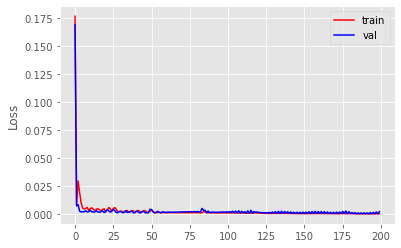

In [28]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.002610623045142593
RMSE = 0.051094256479007436
R-Squared Score = 0.9315994820954001


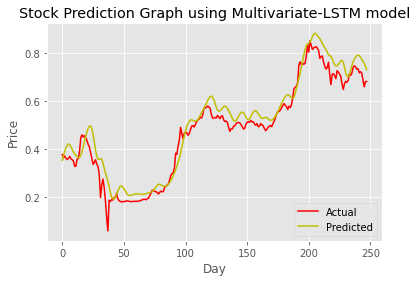

In [29]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
plot_data(true,predicted)